## SARS-CoV-2 Genome Mutator

In [1]:
import io
import os
import sys
import pandas as pd
import numpy as np
import tqdm.notebook as tqdm
import base64

from webapp import *
from webapp1 import mut_generate, translate

from Levenshtein import distance, ratio, hamming
import ipywidgets as widgets
from IPython.display import Javascript, display
from ipywidgets import HTML

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [2]:
MODEL_PATH = "data/ncbi_03/model_gru_32_41"
model = keras.models.load_model(MODEL_PATH)

In [3]:
def run_next_cell(ev=None):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))

In [4]:
file_upload = widgets.FileUpload(accept='.txt', multiple=False, )
display(file_upload)

def on_upload(change):
    run_next_cell()

file_upload.observe(on_upload, names='_counter')

FileUpload(value={}, accept='.txt', description='Upload')

<IPython.core.display.Javascript object>

In [12]:
if len(file_upload.value) > 0:
    file = list(file_upload.value.values())[0]
    data = pd.read_csv(io.BytesIO(file['content']), names=['seq'])
    data['seq_len'] = data.seq.str.len()
else:
    data = None
run_next_cell()
data

<IPython.core.display.Javascript object>

,seq,seq_len
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3813
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3813
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3813
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,3813


In [13]:
generations_value = 1
siblings_value = 1
epsilon_value = 0.1645178355510165

if data is not None:

    generations = widgets.BoundedIntText(
        value=generations_value, min=1, max=10000, step=1, 
        description='Generations', disabled=False
    )
    siblings = widgets.BoundedIntText(
        value=siblings_value, min=1, max=100, step=1, 
        description='Siblings', disabled=False
    )
    epsilon = widgets.BoundedFloatText(
        value=epsilon_value, min=0., max=100., step=0.01, 
        description=r'\(\epsilon\)', disabled=False
    )
    btn_mutate = widgets.Button(
        description='Mutate', icon='check')
    btn_reset = widgets.Button(
        description='Reset', icon='')

    layout = widgets.VBox([
        generations,
        siblings,
        epsilon,
        widgets.HBox([ btn_mutate, btn_reset ])
    ])
    display(layout)

    def on_mutate(change):
        run_next_cell()
        
    def on_reset(change):
        generations.value = generations_value
        siblings.value = siblings_value
        epsilon.value = epsilon_value

    btn_mutate.on_click(on_mutate)
    btn_reset.on_click(on_reset)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
mut_ids = None

if data is not None:

    steps = generations.value * siblings.value
    
    progress = widgets.IntProgress(
        min=0, max=steps,
        description = f'Mutating 0/{steps}',
        bar_style='info',
        style={'bar_color': 'maroon', 'description_width': 'initial'}
    )
    
    label = widgets.Label(value="")

    layout = widgets.HBox([ progress, label ])
    display(layout)

    mut_ids = data.index.values
    mut_ref = np.full_like(mut_ids, -1)
    
    sib_ref = mut_ids
    
    inp_vector = encode_seq(data.seq)
    mut_data = decode_seq(inp_vector)

    for g in range(generations.value):

        sib_vector = None
        
        for s in range(siblings.value):
            i = siblings.value * g + s
            
            v = model.predict([ inp_vector, np.full((len(inp_vector)), epsilon.value)])
            if sib_vector is None:
                sib_vector = v
            else:
                sib_vector = np.append(sib_vector, v, axis=0)

            progress.description = f'Mutating {i + 1}/{steps}'
            progress.value = i + 1

        mut_ref = np.append(mut_ref, np.tile(sib_ref, siblings.value))
        
        next_id = max(mut_ids) + 1
        sib_ref = range(next_id, next_id + len(sib_vector))
        
        mut_ids = np.append(mut_ids, sib_ref)
        mut_data = np.append(mut_data, decode_seq(sib_vector))
                
        inp_vector = sib_vector
        label.value = f'#children {len(mut_data) - len(data)}'
        
    run_next_cell()

<IPython.core.display.Javascript object>

In [25]:
mutations = None

if mut_ids is not None:
    
    mutations = pd.DataFrame({'id': mut_ids, 'ref': mut_ref, 'seq': mut_data})
    mutations = mutations.astype({"id": int, "ref": int})
    mutations.index = mutations.id
    mutations = mutations.drop(columns=['id'])
    mutations.loc[mutations.ref < 0,'ref'] = None
    
    run_next_cell()

<IPython.core.display.Javascript object>

In [ ]:
if mutations is not None:

    mutations['ce'] = None
    mutations['lev'] = None
    mutations['lev_ratio'] = None
    mutations['ham'] = None
    
    for i in tqdm.tqdm(mutations[~pd.isna(mutations.ref)].index):
        
        p = int(mutations[mutations.index == i].ref.values[0])
        x = mutations[mutations.index == i].seq.values[0]
        y = mutations[mutations.index == p].seq.values[0]
        
        mutations.at[i, 'ce'] = keras.losses.CategoricalCrossentropy()(encode_seq([x]), encode_seq([y])).numpy()
        mutations.at[i, 'lev'] = distance(x,y)
        mutations.at[i, 'lev_ratio'] = ratio(x,y)
        mutations.at[i, 'ham'] = hamming(x,y)
    
    mutations
    run_next_cell()

  0%|          | 0/1452 [00:00<?, ?it/s]

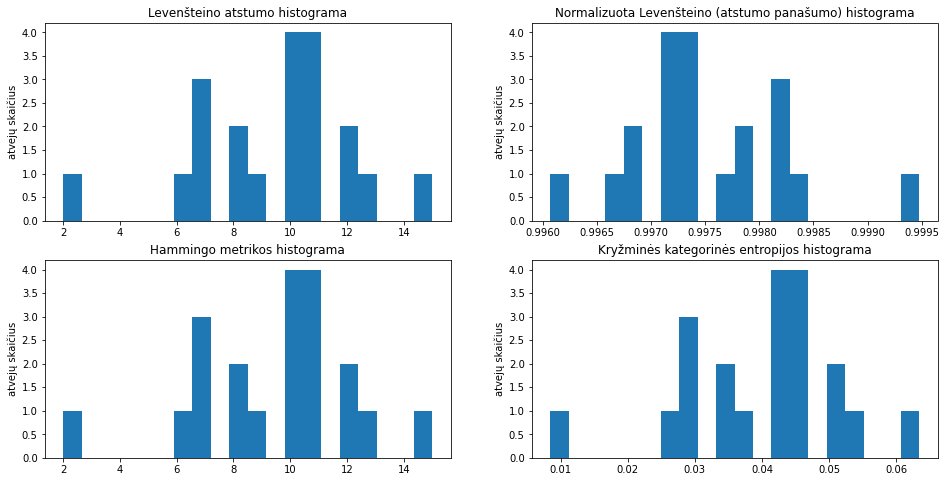

<IPython.core.display.Javascript object>

In [22]:
if mutations is not None:

    fig, ax = plt.subplots(2, 2)

    ax[0,0].hist(mutations[~pd.isna(mutations.ref)].lev, bins=20)
    ax[0,0].set_title("Levenšteino atstumo histograma")
    ax[0,0].set_ylabel("atvejų skaičius")

    ax[0,1].hist(mutations[~pd.isna(mutations.ref)].lev_ratio, bins=20)
    ax[0,1].set_title("Normalizuota Levenšteino (atstumo panašumo) histograma")
    ax[0,1].set_ylabel("atvejų skaičius")

    ax[1,0].hist(mutations[~pd.isna(mutations.ref)].ham, bins=20)
    ax[1,0].set_title("Hammingo metrikos histograma")
    ax[1,0].set_ylabel("atvejų skaičius")

    ax[1,1].hist(mutations[~pd.isna(mutations.ref)].ce, bins=20)
    ax[1,1].set_title("Kryžminės kategorinės entropijos histograma")
    ax[1,1].set_ylabel("atvejų skaičius")

    plt.show()
    
    run_next_cell()

In [23]:
if mutations is not None:

    filename = 'mutations.csv'
    b64 = base64.b64encode(mutations.to_csv().encode())
    payload = b64.decode()

    html_buttons = '''<html>
    <head>
    <meta name="viewport" content="width=device-width, initial-scale=1">
    </head>
    <body>
    <a download="{filename}" href="data:text/csv;base64,{payload}" download>
    <button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning">Download File</button>
    </a>
    </body>
    </html>
    '''

    html_button = html_buttons.format(payload=payload,filename=filename)
    display(HTML(html_button))

HTML(value='<html>\n    <head>\n    <meta name="viewport" content="width=device-width, initial-scale=1">\n    …